## Package and data imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score


In [2]:
#Data import
df = pd.read_csv('../datasets/train_processed.csv')

## Aside: Categorical Variable Encoding

Several categorical variables in this data set may convey information but may add too many parameters to our model (and lead to overfitting) if one-hot encoded.  Later, we will use LASSO regularized regression to drop those dummy variables produced by one-hot encoding that are not sufficiently explanatory of home sale prices.  However, we may also want to try a more direct approach to reduce the number of parameters in our model.

Instead of one-hot encoding all of these categorical variables, we can also encode them in a simpler form.  The function below carries out one possible such encoding; it turns a categorical variable into a numeric variable that only takes on the values 1, 0 and -1 based on whether they're associated with higher or lower values of our target variable `SalePrice`.  1 corresponds to "above average", 0 to "about average", and -1 to "below average."  See the example below, after the function's code.

In [3]:
def above_below_mid(df, col, target):
    '''
    Inputs:
    -A Pandas dataframe df
    -The name of a (categorical) column in df
    -The name of the target (numeric) column to be predicted by modeling
    
    Output:
    Returns a dicticonary that sorts each value appearing in that column
    to 1 if it's associated with above-median target value, -1 if it's
    associated with a below-median target value, and 0 if it's associated
    with an approximately-median target value.
    
    Specifically, this function does:
    1. For each value 's' that is taken on in that column,
     find the conditional median of the target value given that
     df[col]=='s';
    2. Find the range of these conditional medians, i.e.
     [LOWEST CND MEDIAN, HIGHEST CND MEDIAN];
    3. For each value 's' that is taken on in that column,
      -Appends {'s':1} to the output dict if the conditional median
      for 's' was in the top third of this range;
      -Appends {'s':0} if it was in the middle thrid;
      -Appends {'s':-1} if it was in the bottom third.
    '''
    
    output={}
    meds={}
    pop_med = df[target].median()
    
    #Make a dictionary of conditional medians for each value in the column
    for name in df[col].unique():
        
        #Find conditional median of target for that value
        cnd_med = df[ df[col]==name ][target].median()
        meds[name] = cnd_med
            
    #Find the most extreme conditional medians
    highest_med = max(meds.values())
    lowest_med = min(meds.values())
    diff = highest_med - lowest_med

    #Group the column's values based on whether their conditional target mean
    #is in the lower thrid (-1), upper third (1), or middle third (0)
    
    for name in meds.keys():
        if meds[name] < lowest_med + diff/3:
            output[name] = -1
        elif meds[name] > highest_med - diff/3:
            output[name] = 1
        else:
            output[name] = 0
    
    return output
    

In [4]:
#An example
above_below_mid(df, col='Condition 1', target='SalePrice')

{'RRAe': -1,
 'Norm': 0,
 'PosA': 1,
 'Artery': -1,
 'Feedr': -1,
 'PosN': 1,
 'RRAn': 0,
 'RRNe': -1,
 'RRNn': 1}

Those strings that are assigned -1 can be thought of as associated with below-average home prices; those assigned +1 are associated with above-average home prices; and those assigned 0 are associated with approximately average prices.

Looking at the [data description](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) for the feature `Condition 1`, we can see that these assignments make a good deal of sense.  The value 'RRAe' is mapped to -1, which fits with the idea that being *adjacent to a railrod* probably leads to lower home prices.  The value 'Norm' is mapped to 0, which means that "Normal" (according to the data description) houses have approximately average prices.  'PosA' is described as "Adjacent to postive off-site feature," and we see that it's mapped to 1, corresponding to higher-than-average home prices.

We will return to encoding the categorical variables later.  For now, we'll deal with the data types.

# Exploratory Data Analysis

Before building any predictive models, we'll want to examine the relationships between the various features and our target variable `SalePrice`.  We'll start with the numeric features, as we can easily examine their correlations with sale price.

In [5]:
#Extract the numeric and categorical features
numerics = []
categoricals = []

for feature in df.dtypes.index:
    if (df.dtypes[feature] == 'int64') or (df.dtypes[feature] == 'float64'):
        numerics.append(feature)
    else:
        categoricals.append(feature)
        
print(f"Numeric variables include {numerics[:5]}")
print(f"Categorical variables incl {categoricals[:5]}")

Numeric variables include ['Id', 'Lot Frontage', 'Lot Area', 'Lot Shape', 'Utilities']
Categorical variables incl ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour']


In [6]:
#Remove the ID number since it's not predictive
numerics.remove('Id')

## Numeric variables' correlations with `SalePrice`

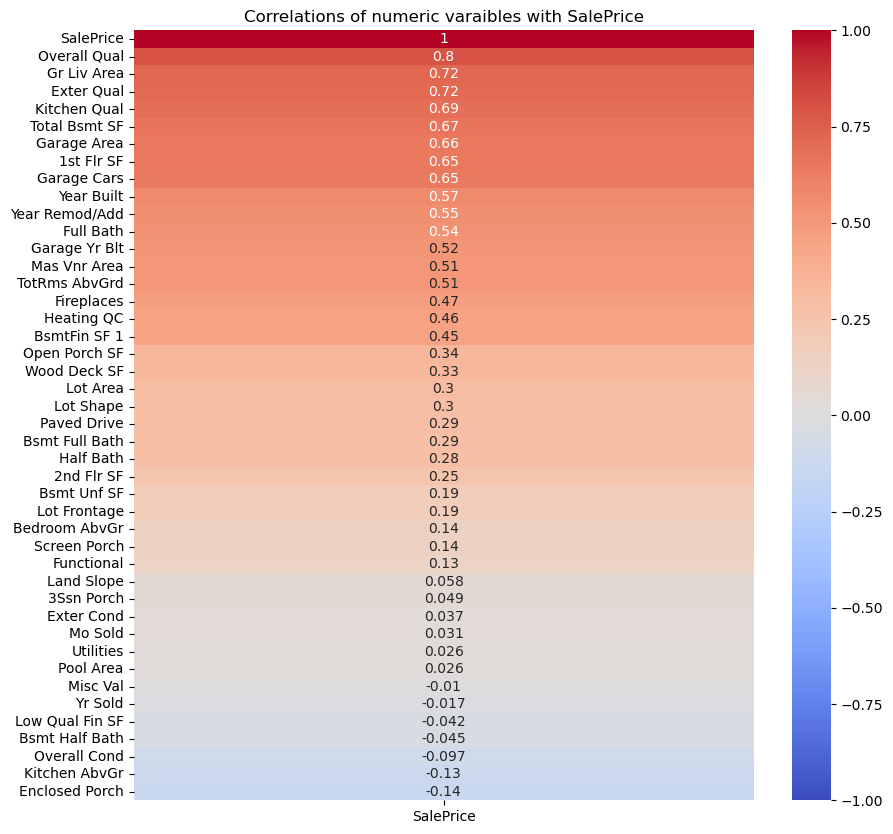

In [41]:
#Get a heatmap of correlations of numeric features with SalePrice
plt.figure(figsize=(10,10))
sns.heatmap(df[numerics].corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False),
           cmap = 'coolwarm',
           vmax = 1,
           vmin = -1,
           annot = True);
plt.title('Correlations of numeric varaibles with SalePrice');

Those features at the top of this list seem like great candidates to include in a basic regression trying to predict `SalePrice`.  Those at the bottom are much less likely to be useful.

For now, let's make a list of those numeric variablenames that are most correlated with `SalePrice` (say, correlation greater than .3):

In [67]:
nums_strong = [x for x in df[numerics].columns if df[x].corr(df['SalePrice'])>.3]
nums_strong

['Lot Area',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'Exter Qual',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 'Heating QC',
 '1st Flr SF',
 'Gr Liv Area',
 'Full Bath',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'SalePrice']

### Numeric features' relationships with each other

Now let's make sure none of these features are too strongly correlated with each other:

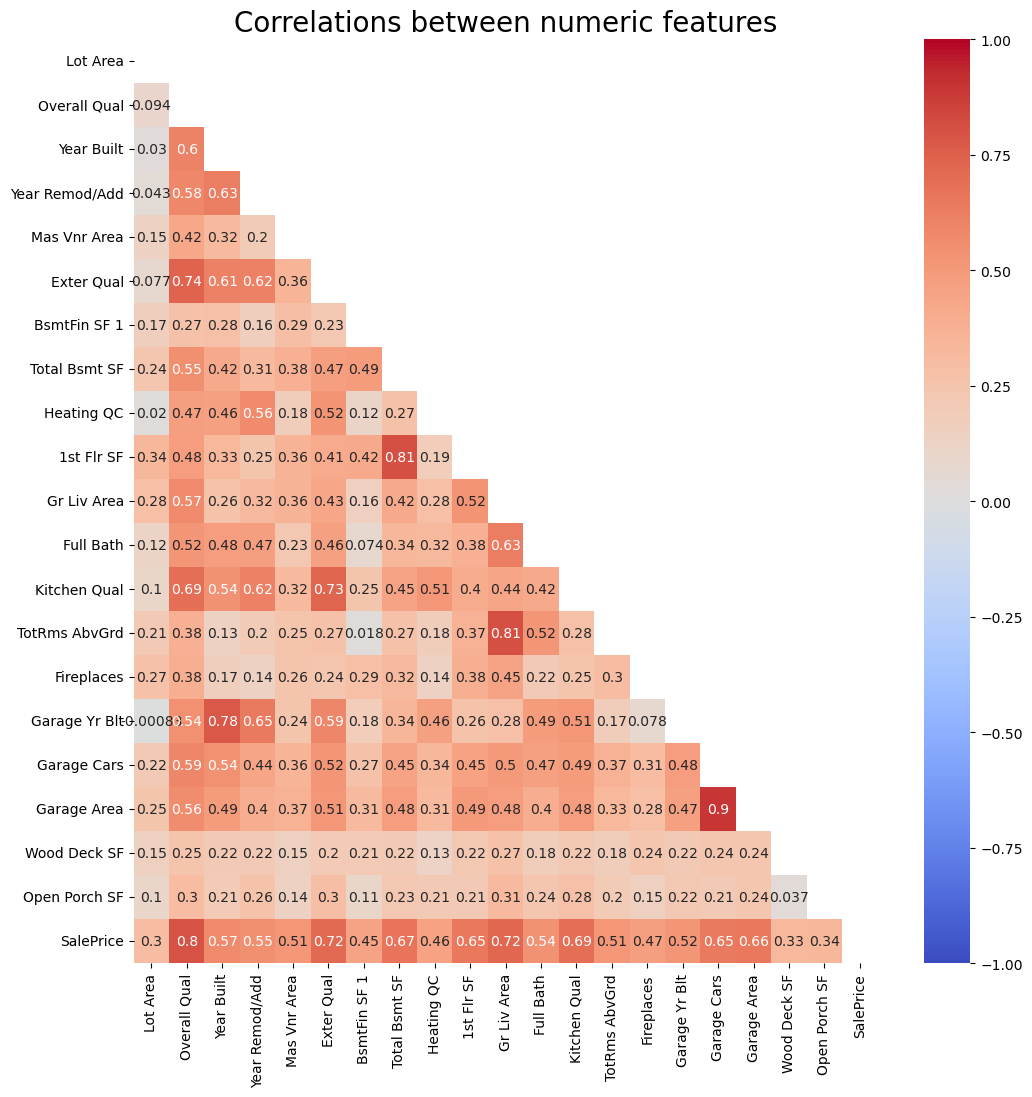

In [68]:
corr = df[nums_strong].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(12,12));
sns.heatmap(corr,
            cmap = 'coolwarm',
            vmin=-1,
            vmax=1,
            annot=True,
            mask=mask);
plt.title('Correlations between numeric features', size=20);

We see that `Garage Area` and `Garage Cars` are highly correlated - which makes sense, since the latter measures how may cars fit in the garage!  This seems like a good reason to drop this feature from our list, as it's likely measuring almost the same thing as `Garage Area` (and `Garage Area` was slightly *more* correlated with `SalePrice`).

Some other variables have correlations as high as .81, but there's no obvious reason that they should be multicollinear.  So we'll leave them in our list for now.

In [69]:
#Remove the multicollinear and target variables from our list of strong numeric vars
nums_strong.remove('Garage Cars')
nums_strong.remove('SalePrice')
len(nums_strong)

19

Finally, let's make a pair plots to examine the relationships between those features that have a correlation with `SalePrice` of at least .6:

In [74]:
nums_vstrong = [x for x in df[numerics].columns if df[x].corr(df['SalePrice'])>.6]
nums_vstrong.remove('Garage Cars')

8

<Figure size 1400x1400 with 0 Axes>

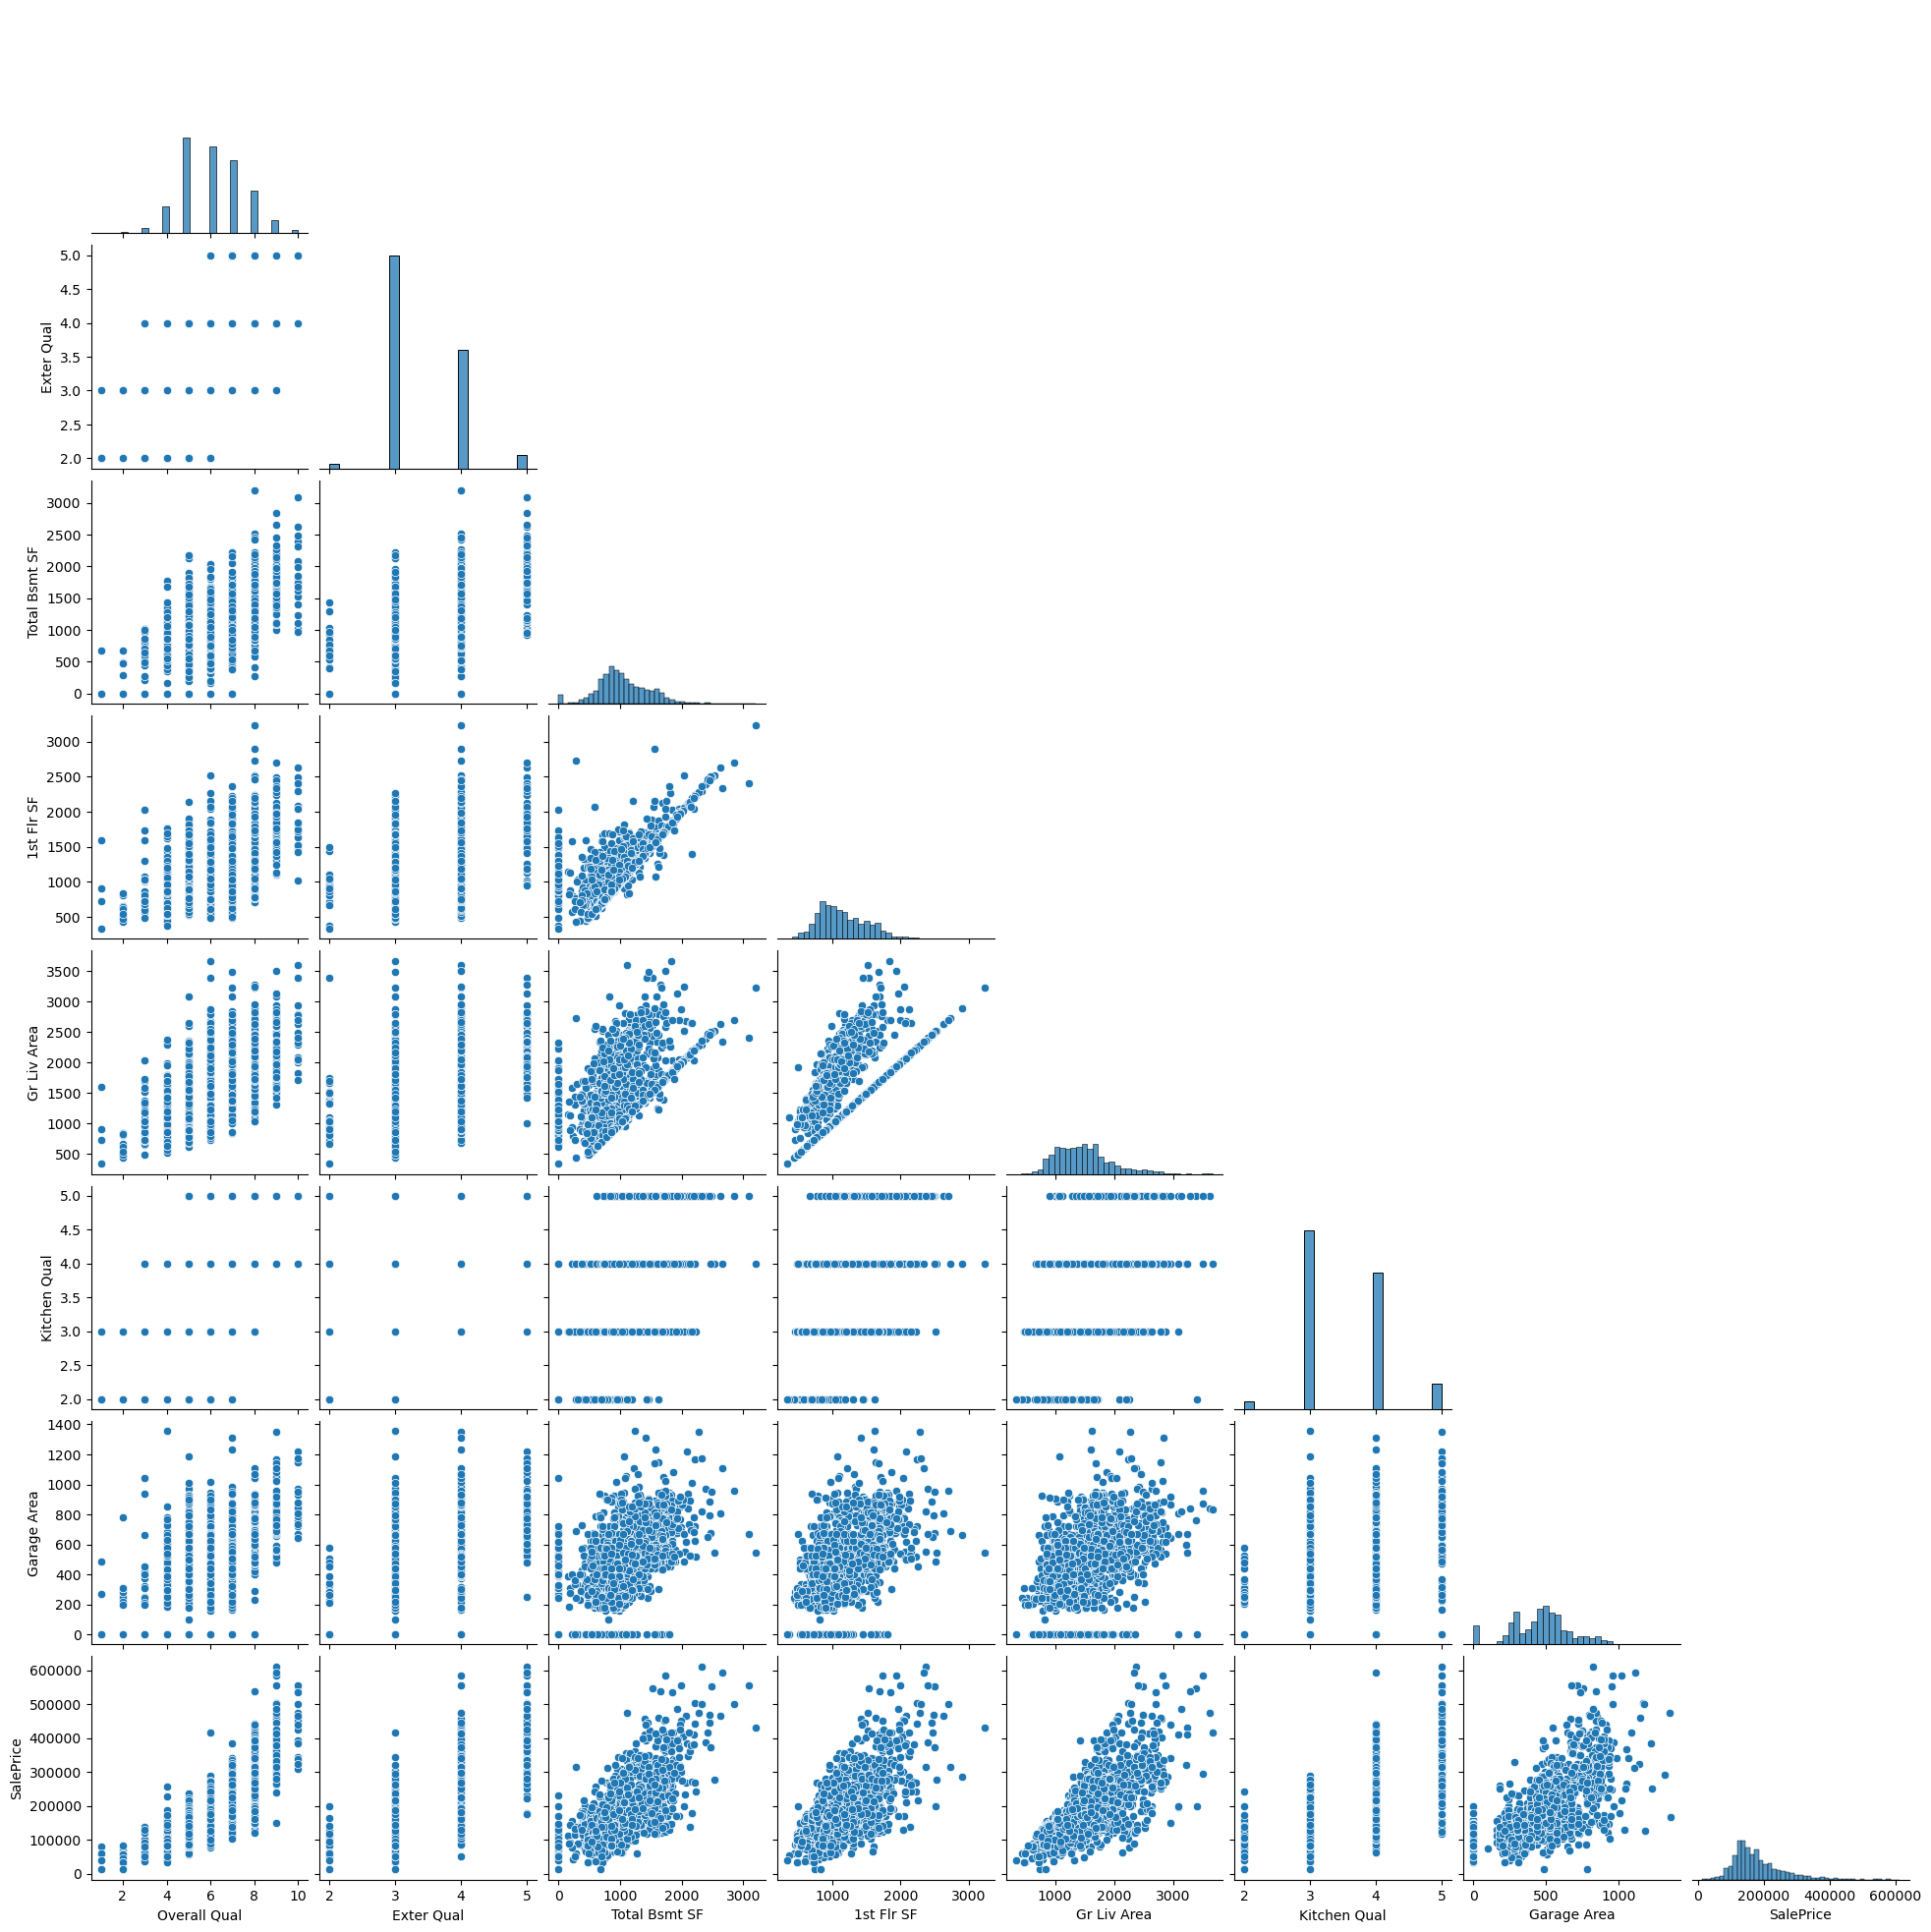

In [76]:
plt.figure(figsize=(14,14));

sns.pairplot(df[nums_vstrong], corner=True);

As we can see from the bottom row, most of these features do seem to have an approximately linear relationship with `SalePrice`.  There is a little bit of "fanning out" (heteroskedasticity) of the sale prices as the features get larger, but not so much that something like a logarithmic transformation of `SalePrice` seems necessary.

We also see that some of these otherwise-regular-looking plots contain vertical or horizontal lines at 0.  These simply account for the mass homes with e.g. zero basement square footage or garage square footage (because they don't have a basement / don't have a garage).

Finally, there are some diagonal lines that appear in some of the scatterplots of the square footage variables against each other.  These likely indicate cases where the person who assessed the home's square footage just split up the total square footage roughly evenly between its various floors/regions (perhaps because the house is very regularly shaped).

In [85]:
#Record for later those numeric features most strongly correlated with SalePrice
nums_vstrong.remove('SalePrice')
len(nums_vstrong)

7

## Categorical variables' correlations with `SalePrice`

In order to be able to examine correlations of categorical variables with `SalePrice`, we'll first have to find a way to encode those variables as numbers.  Rather than make dummies of everything (and get a truly enormous heatmap), we'll start by just applying the `above_below_mid` transformation function from the "Aside: Encoding Categorical Variables" section above.  This function encodes those categories that are associated with "above average" `SalePrice` as 1, those associated with below average `SalePrice` as -1, and those associated with approximately average `SalePrice` as 0.

In [8]:
cat_df = df[categoricals + ['SalePrice']]

#Encode all the non-SalePrice values with above_below_mid
for col in cat_df.columns:
    if col != 'SalePrice':
        map_dict = above_below_mid(cat_df, col, 'SalePrice')
        cat_df[col] = cat_df.loc[:,col].map(map_dict)
        
cat_df.head()

/var/folders/5v/3x2_29n942n4k09n89jp09m80000gn/T/ipykernel_17886/3265581249.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df[col] = cat_df.loc[:,col].map(map_dict)
/var/folders/5v/3x2_29n942n4k09n89jp09m80000gn/T/ipykernel_17886/3265581249.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df[col] = cat_df.loc[:,col].map(map_dict)
/var/folders/5v/3x2_29n942n4k09n89jp09m80000gn/T/ipykernel_17886/3265581249.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,MS SubClass,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,...,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Pool QC,Fence,Misc Feature,Sale Type,SalePrice
0,1,1,1,1,-1,1,-1,-1,-1,1,...,-1,1,1,0,1,-1,1,-1,0,130500
1,1,1,1,1,-1,1,0,0,-1,1,...,-1,1,1,0,1,-1,1,-1,0,220000
2,0,1,1,1,-1,-1,-1,0,-1,1,...,-1,-1,-1,0,1,-1,1,-1,0,109000
3,1,1,1,1,-1,-1,0,0,-1,1,...,-1,1,1,0,1,-1,1,-1,0,174000
4,-1,1,1,1,-1,-1,0,0,-1,1,...,-1,-1,-1,0,1,-1,1,-1,0,138500


In [29]:
cat_df['SalePrice'].corr(cat_df['Bsmt Qual'])

0.6934829911486067

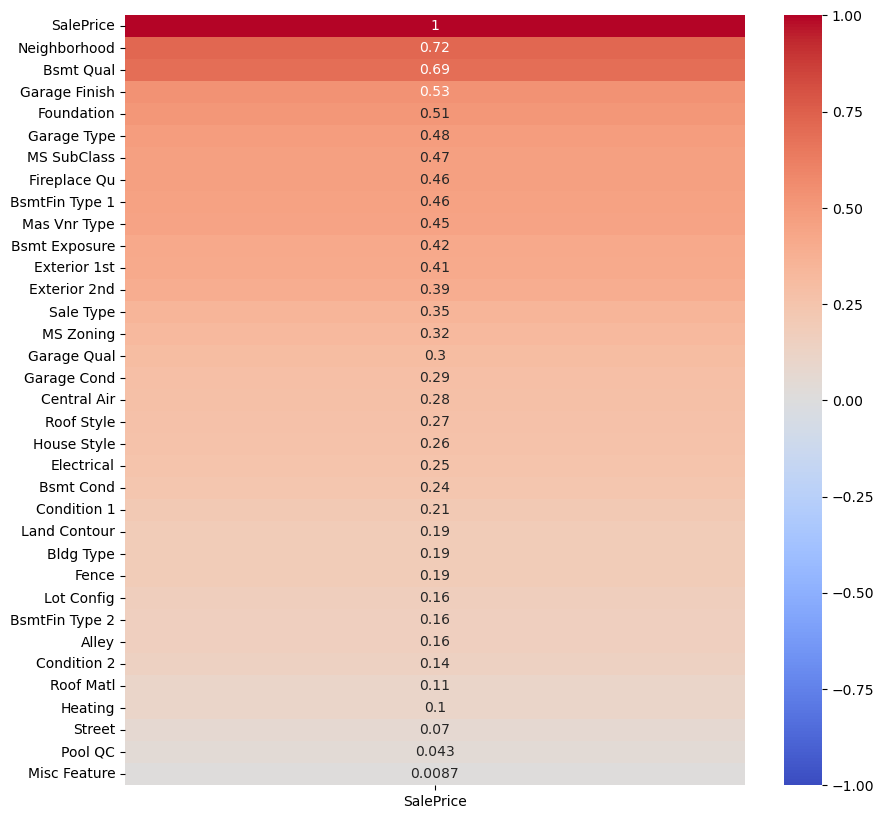

In [11]:
#Get a heatmap of correlations of categorical features with SalePrice
plt.figure(figsize=(10,10))
sns.heatmap(cat_df.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False),
           cmap = 'coolwarm',
           vmax = 1,
           vmin = -1,
           annot = True);

Those features at the top of this list are likely to be somewhat informative when included in a regression.  Those at the bottom are less likely to be informative.  Let's get a list  of those variables that (after the encoding above) have a correlation with `SalePrice` of magnitude at least .3:

In [86]:
cats_strong = [x for x in cat_df.columns if cat_df[x].corr(df['SalePrice'])>.3]
cats_strong

['MS SubClass',
 'MS Zoning',
 'Neighborhood',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Sale Type',
 'SalePrice']

### (Transformed) Categorical Variables' relationships with each other

Now let's make sure none of these categorical features are too strongly correlated with each other:

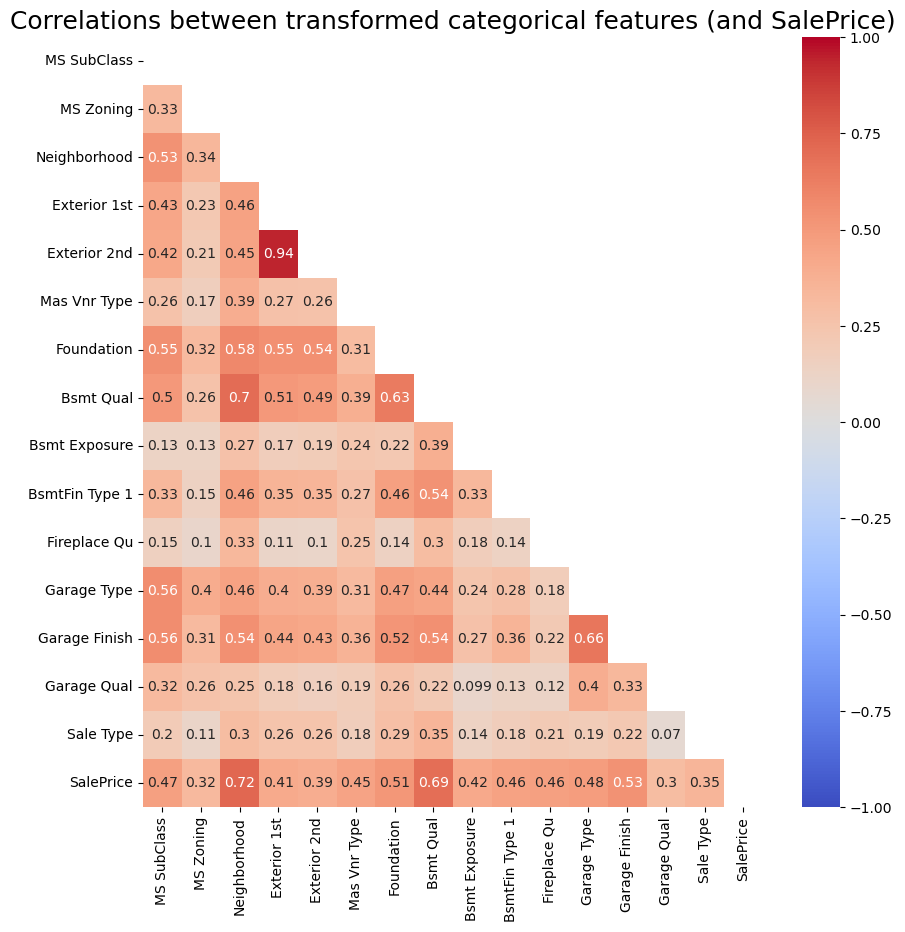

In [80]:
corr = cat_df[cats_strong].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(10,10));
sns.heatmap(corr,
            cmap = 'coolwarm',
            vmin=-1,
            vmax=1,
            annot=True,
            mask=mask);
plt.title('Correlations between transformed categorical features (and SalePrice)', size=18);

We see that `Exterior 1st` and `Exterior 2nd` are highly correlated.  Looking at the [data description](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), we see that `Exterior 1st` represents the type of material covering the house, while `Exterior 2nd` represents the *second type of material covering the house, if there is any different from the primary one*.  It seems that the vast majority of homes only have one type of material covering them, leading `Exterior 1st` and `Exterior 2nd` to be nearly identical variables.

For this reason, we'll drop `Exterior 2nd` (the one less correlated with `SalePrice`) from our list of categorical variables to consider in our initial model.

Some other variables have correlations as high as .72, but there's no obvious reason that they should be multicollinear.  So we'll leave them in our list for now.

In [81]:
#Remove the multicollinear and target variables from our list of strong numeric vars
cats_strong.remove('Exterior 2nd')
cats_strong.remove('SalePrice')
len(cats_strong)

14

Finally, let's make a list of those categorical variables that are *extremely strongly* correlated with `SalePrice`.

In [87]:
cats_vstrong = [x for x in cat_df.columns if cat_df[x].corr(df['SalePrice'])>.6]
cats_vstrong.remove('SalePrice')
cats_vstrong

['Neighborhood', 'Bsmt Qual']

# Regression Modeling

We now have a list `cats_strong` of the 14 categorical variables that are (after transformation) that have a correlation with `SalePrice` of more than .3.  Combining these with our similar list `nums_strong` of 19 numeric variables, we have a good starting point of which varaibles to include in a linear regression to predict `SalePrice`.

In case this is too many varaibles, we also have the lists `nums_vstrong` (7 varaibles) and `cats_vstrong` (2 varaibles), which include only those variables whose correlation with `SalePrice` is at more than .6.

When we include categorical varaibles in a regression, we need to encode them as numeric variables in some way.  We will try two methods:
1. One-hot encoding;
2. `above_below_mid` encoding as above.

We will use a LASSO regularized regression to then drop insignificant features from our regression.  I suspect that the net result after applying LASSO will be better (in terms of cross-val and testing $R^2$) when using approach \#1 above, as LASSO eliminates the non-useful dummies.  But we shall see!

## Helper Functions

We'll want to automate two separate processes:
1. Transforming the data according to certain specifications;
2. Running various regressions on data that's already properly transformed.

We write functions below that perform these tasks.

In [90]:
def transform_data(df, numerics, categoricals,
                   cat_transform_dict = {},
                   abms = [],
                   target = None,
                   standardize=False,
                   drop_first=False):
    '''
Inputs:
df: A Pandas dataframe
numerics: A list of column names of the numeric variables to be
    included in the outputted dataframe (for use in regression)
categoricals: A list of column names of the categorical vars to be
    included in the outputted dataframe (for use in regression).
    By default these will be one-hot encoded, but see below for
    other methods of encoding.
    
Parameters:
cat_transform_dict: A dictionary of dictionaries; its keys are
    the names of columns you want transformed according to the
    dictionary that that key keys to.  For example, if
    cat_transform_dict includes the item
    'Quality' : {'Gd':1, 'Bd':-1},
    then the entries in the column 'Qaulity' will be mapped
    'Gd' -> 1, 'Bd' -> -1, and ANY OTHER STRINGS NOT APPEARING
    IN THIS 'Quality' DICT WILL BE MAPPED TO ZERO.
    
    By default cat_transform_dict is empty.
    Any columns whose names do not appear as keys in
    cat_transform_dict will not be transformed in this way;
    they will be one-hot encoded (by default) or above_below_mid
    encoded (if the list abms contains them).
    
abms: A list of those vars in categoricals that you want to be
    above_below_mid encoded (as opposed to one-hot encoded).
    By default this list is empty, meaning all vars in categoricals
    will be one-hot encoded (unless you specified that they be
    cat_transform_dict encoded).
    In order for this encoding to work, you MUST specify a
    target variable in the parameter 'target'.
    
target: The column name of the target variable you want to predict.
    By default this is None.  If set to a particular column name,
    the outputted dictionary from this function will include
    that column as a separate dataframe under the key 'y'.

standardize: If set to True, will standardize all variables before
    returning them in the output dataframe.
    
drop_first: If set to True, will drop the first dummy varaible
    made in each one-hot encoding of a categorical variable.
    
    
Outputs:
Returns a dictionary containing three items:
'data' : The dataframe df that has been transformed according to
    the inputs / parameteres given.  All varaibles not appearing
    in 'numerics' or 'categoricals' will be dropped.
    
'y': If a 'target' column name was given, this target column's
    values will be returned here.
    
'ct_dict': A dictionary. Each column name that was in 'abms' will
    be a key; that column's value will be a dictionary specifying
    how that column was ultimately transformed. (See the
    description of the input parameter cat_transform_dict)
    
'dropped_names': If any categorical variables were one-hot encoded
    and 'drop_first' was set to True, then this item will include
    the names of all the automatically-generated dummy variables
    that happened to be dropped by drop_first.
    '''

    pass

In [ ]:
transform_data()

## First attempt: Regression only on variables most strongly correlated with `SalePrice`

## Regression using 

Some of these features are likely to be multicollinear: e.g. combining living area + kitchens + baths is likely to yiled something close to total square footage.

In [ ]:
#Make a list of features that are likely to not be multicollinear
features = ['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
     '1st Flr SF', '2nd Flr SF', 'Fireplaces', 'Wood Deck SF', 'Open Porch SF',
     'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']

X=df[features]
X.head()

In [ ]:
y = df['SalePrice']

In [ ]:
#Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
#Fit the linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

preds_train = lr.predict(X_train)
preds_test = lr.predict(X_test)

resids_train = y_train - preds_train
resids_test = y_test - preds_test

In [ ]:
#Examine the coefficients
pd.Series(lr.coef_, index = X.columns)

In [ ]:
#Find R-squared on training data
lr.score(X_train, y_train)

In [ ]:
#Compare to R-squared on testing data
lr.score(X_test, y_test)

In [ ]:
#Cross validation
cross_val_score(lr, X_train, y_train).mean()

In [ ]:
#Cross-val score on entire dataset
cross_val_score(lr, X, y).mean()

In [ ]:
#Compute RMSE on test set
metrics.mean_squared_error(y_test, preds_test, squared=False)

## Make a Kaggle submission

In [ ]:
kaggle = pd.read_csv('./datasets/test_cleaned.csv')

In [ ]:
X_to_pred = kaggle[features]
X_to_pred.head()

In [ ]:
kaggle_preds = lr.predict(X_to_pred)

In [ ]:
kaggle['SalePrice'] = kaggle_preds
output = kaggle[['Id', 'SalePrice']]
output.head()

In [ ]:
output.to_csv('./datasets/sub_first_try.csv', index=False)

In [ ]:
regression(df, features, 'SalePrice', folds=4, random_state=42, test_size=.2,
          outputs = ['crossval', 'r2_train', 'r2_test', 'rmse_train', 'rmse_test'])

# Helper functions

### Regression fitting and evaluation

In [ ]:
def regression(df, features, target,
        test_size=.25, random_state=None, folds=5, outputs=['crossval']):
    '''
    Inputs:
    df: A Pandas dataframe
    features: A list of column names in df that you want included as regressors
    target: The name of a column in df that you want as the dependent variable
    
    Parameters:
    test_size: Proportion of df to use as a test data set. Defaults to .25.
    random_state: Random state for train-test split. Defaults to None.
    folds: The number of folds to be used for cross-val scoring of the model.
    outputs: A list of strings indicating the items this function should output.
    
        You can enter the following arguments (defaults to only 'crossval'):
        
        'crossval': The cross-val scores of the model on the UNION of
                    train+test sets
        'r2_test': R-Squared value from the test data set
        'r2_train': R-squared value from the training data set
        'rmse_test': Root mean-squared error of model on test data
        'rmse_train': Root mean-squared error of model on train data
        
        'lr': The sklearn linear model fitted on the UNION of
              training and test sets
        'coefs': A Pandas series of the fitted coefs from the UNION of
                 train+test sets
        'intercept': The fitted intercept coef from the UNION of train+test sets
        
        'lr_train': The sklearn linear model fitted on the training set
        'coefs_train': A Pandas series of the fitted coefs from the training set
        'intercept_train': The fitted intercept coef from the training set
        
        'train_indices': An array of the indices of observations used in train set
        'test_indices': An array of the indices of observations used in test set
    
    Output:
    Splits df into training and test sets.  Trains a linear model with
    X=df[features] and y=df[target], then returns the desired items listed
    in 'outputs'.  
    '''
    
    X = df[features]
    y = df[target]
    
    #Initialize a dictionary for outputs
    returns = {}
    
    
    
    
    
    
    #If the only desired output is crossval, then we don't need to train a model ourselves
    if outputs == ['crossval']:
        return {'crossval' : cross_val_score(LinearRegression(), X, y, cv=folds)}
    
    
    
    
    
    
    
    
    
    
    #If none of the desired outputs include 'train' or 'test', then we only need
    #to fit a model on the ENTIRE data set (no train/test splitting needed)
    
    notrain = 'train' not in ''.join(outputs)
    notest = 'test' not in ''.join(outputs)
    
    if notrain and notest:
    
        #Fit a linear model on the entire data set
        lr = LinearRegression()
        lr.fit(X, y)
        
        #For each type of desired output, add it to our output dictionary
        for x in outputs:
            if x=='lr':
                returns[x] = lr
            if x=='coefs':
                returns[x] = lr.coef_
            if x=='intercept':
                returns[x] = lr.intercept_
            if x=='crossval':
                returns[x] = cross_val_score(LinearRegression(), X, y, cv=folds)
        return returns
    
    
    
    
    
    
    #Now check if ALL the desired outputs (other than 'crossval') reference 'train'
    #or 'test'.  If so, then we don't need to fit a regression on the WHOLE
    #data set - only on the train set.
    
    #Initialize an indicator to see if all desired outputs (except possibly 'crossval')
    #contain 'train' or 'test'
    indicator = 1
    
    for x in outputs:
        if x=='crossval':
            continue
        elif 'train' in x:
            continue
        elif 'test' in x:
            continue
        else:
            indicator = 0
            break
    
    #If no desired outputs require a whole-data-set fitting...
    if indicator == 1:
        
        #Split the data set
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            random_state=random_state,
                                                            test_size=test_size)
        #Fit a linear model on the training set
        lr_train = LinearRegression()
        lr_train.fit(X_train, y_train)
    
        #For each type of desired output, add it to our output dictionary
        for x in outputs:
            if x=='crossval':
                returns[x] = cross_val_score(LinearRegression(), X, y, cv=folds)
            if x=='r2_test':
                returns[x] = lr_train.score(X_test, y_test)
            if x=='r2_train':
                returns[x] = lr_train.score(X_train, y_train)
            if x=='rmse_test':
                returns[x] = metrics.mean_squared_error(y_test, lr_train.predict(X_test), squared=False)
            if x=='rmse_train':
                returns[x] = metrics.mean_squared_error(y_train, lr_train.predict(X_train), squared=False)
            if x=='lr_train':
                returns[x] = lr_train
            if x=='coefs_train':
                returns[x] = lr_train.coef_
            if x=='intercept_train':
                returns[x] = lr_train.intercept_
            if x=='train_indices':
                returns[x] = X_train.index
            if x=='test_indices':
                returns[x] = X_test.index
        return returns
    
    
    
    
    
    
    
    
    #If neither of the above conditions is met, then we need to fit regression models
    #on BOTH the whole data set and a test set.
    else:
        
        #Split the data set
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            random_state=random_state,
                                                            test_size=test_size)
        #Fit a linear model on the training set
        lr_train = LinearRegression()
        lr_train.fit(X_train, y_train)
        
        #Fit a separate linear model on the WHOLE data set
        lr = LinearRegression()
        lr.fit(X, y)
        
        #For each type of desired output, add it to our output dictionary
        for x in outputs:
            if x=='crossval':
                returns[x] = cross_val_score(LinearRegression(), X, y, cv=folds)
            if x=='r2_test':
                returns[x] = lr_train.score(X_test, y_test)
            if x=='r2_train':
                returns[x] = lr_train.score(X_train, y_train)
            if x=='rmse_test':
                returns[x] = metrics.mean_squared_error(y_test, lr_train.predict(X_test), squared=False)
            if x=='rmse_train':
                returns[x] = metrics.mean_squared_error(y_train, lr_train.predict(X_train), squared=False)
            if x=='lr_train':
                returns[x] = lr_train
            if x=='coefs_train':
                returns[x] = lr_train.coef_
            if x=='intercept_train':
                returns[x] = lr_train.intercept_
            if x=='train_indices':
                returns[x] = X_train.index
            if x=='test_indices':
                returns[x] = X_test.index
            if x=='lr':
                returns[x] = lr
            if x=='coefs':
                returns[x] = lr.coef_
            if x=='intercept':
                returns[x] = lr.intercept_
        return returns
    